Lorenzo stated that (for the bar_compare_count plots - species count plots) "...you need to find a way to deal with the TS numbers as...they skew everything else making the differences between mono and beamformer much less visible. Again, you could just report the % of increase in number of detected occurrences for each species, and then average them across all...I'd work with % though, and not absolute counts, specifically because of the TS being so high"

So, we will look to make these changes...

First, let's only plot certain species (ones around the average count)

In [23]:
import json
import matplotlib.pyplot as plt
import numpy as np


def get_initials(species_name):
    """Extract the intials from a species' full name"""
    # Split the name into individual words
    words = species_name.split()

    # Extract the first character of each word
    initials = [word[0].upper() for word in words]

    # Return the initials as a string
    return ''.join(initials)


def setup_new_plot(xlabel, ylabel, title):
    """Initialises a new matplotlib plot, with desired parameters"""
    plt.figure(figsize=(18, 12))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)

def read_results_from_file(file_path):
    """Read the BirdNET detections from a file"""

    with open(file_path, 'r') as file:
        results_dict = json.load(file)

    return results_dict


def get_unique_species(arr):
    """Create a list of all unique species (from either channel)"""
    unique_species = []
    for dictionary in arr:            # Iterate through all dictionaries
        unique_species.extend(list(dictionary.keys()))        # Add all species to a new list
    unique_species = list(set(unique_species))          # Remove duplicates from new list

    return unique_species


def barchart_count_comparison(mono_data, bf_data, location):
    """Creates a boxplot to compare species counts of mono-channel vs beamformed
    --> Split into groups (1 group per species) - for side-by-side comparison"""

    title = f"Species counts for detections above 0.7 confidence - Mono-channel vs Beamformed Recordings - {location}"
    setup_new_plot("Species Initials", "Species Count", title)

    count_data_list = [mono_data, bf_data]
    barchart_count_mono = []
    barchart_count_bf = []
    barchart_labels = []

    species_list = get_unique_species(count_data_list)

    # Extract count data to a list...
    for species in species_list:
        barchart_labels.append(get_initials(species))

        if species in mono_data:
            barchart_count_mono.append(mono_data[species])
        else:
            barchart_count_mono.append(0)

        if species in bf_data:
            barchart_count_bf.append(bf_data[species])
        else:
            barchart_count_bf.append(0)


    # ADJUSTMENT----------------------------------------------------------------------------------------
    mean_count = np.mean(barchart_count_mono)
    mean_mod = 4
    max_count_for_chart = mean_count*mean_mod          # Only plot the species with counts within 0.5* or 2* the mean (to avoid skewing)
    min_count_for_chart = mean_count/mean_mod


    modded_bf = []
    modded_mono = []
    modded_labels = []

    for i, count in enumerate(barchart_count_mono):
        if count > 20:                  # Sufficient sample size
            if count < max_count_for_chart and count > min_count_for_chart:
                modded_bf.append(barchart_count_bf[i])
                modded_mono.append(barchart_count_mono[i])
                modded_labels.append(barchart_labels[i])
    # ADJUSTMENT----------------------------------------------------------------------------------------


    if barchart_labels:        # If we have some data to plot (otherwise, = [], which acts as False)
        # Plot the data - unfortunately, for side-by-side groups, we have to lay it out manually...
        plt.bar(np.array(range(len(modded_mono)))*2.0-0.3, modded_mono, width=0.6, color='#D7191C')
        plt.bar(np.array(range(len(modded_bf)))*2.0+0.3, modded_bf, width=0.6, color='#2C7BB6')

        # draw temporary red and blue lines and use them to create a legend
        plt.plot([], c='#D7191C', label='Mono-channel')
        plt.plot([], c='#2C7BB6', label='Beamformed')
        plt.legend()

        plt.xticks(range(0, len(modded_labels) * 2, 2), modded_labels)
        plt.xlim(-2, len(modded_labels)*2)
        # plt.ylim(0.4, 1)
        plt.tight_layout()

        plt.show()

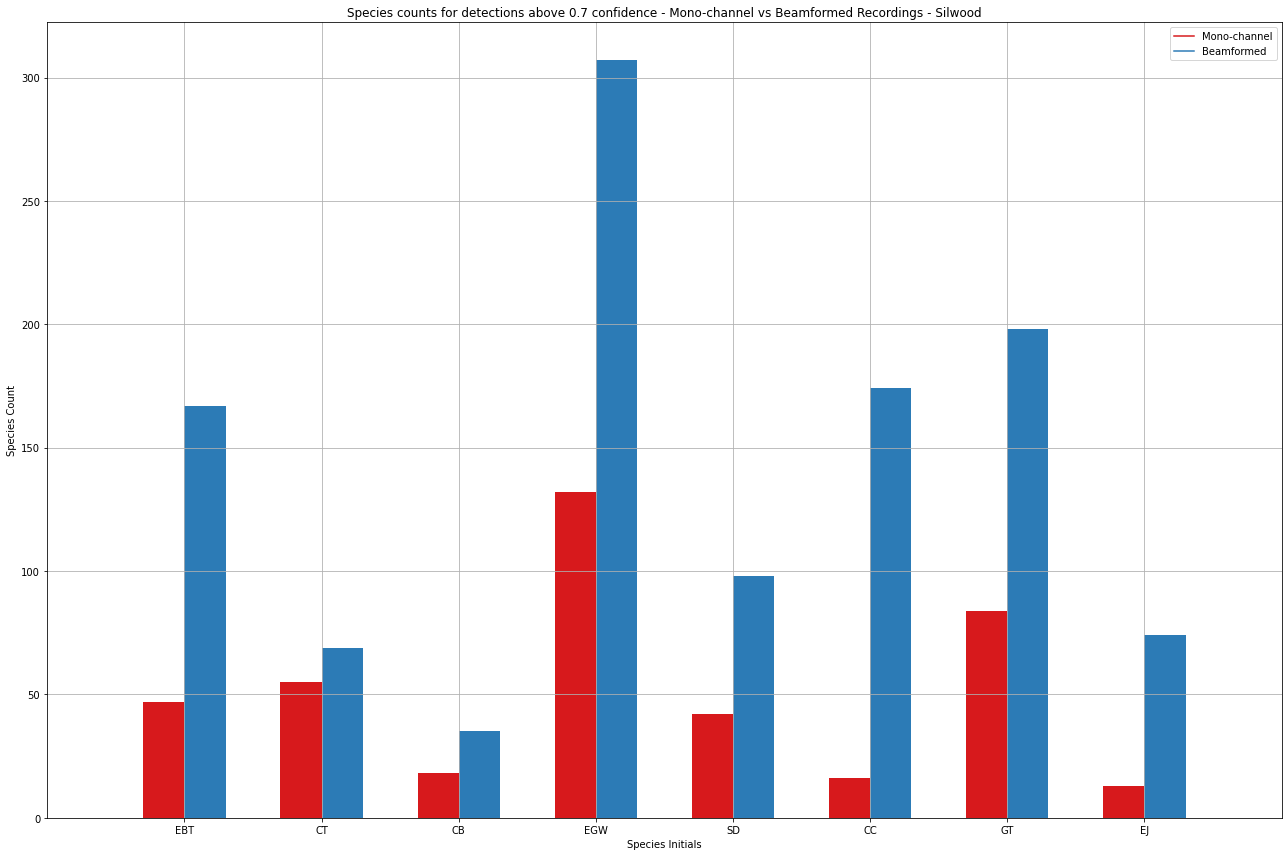

In [24]:
file_path = "data/processed/silwood/A1/species_counts.json"

mono_data = read_results_from_file(file_path)["mono_channel"]
bf_data = read_results_from_file(file_path)["beamformed"]

barchart_count_comparison(mono_data_1, bf_data_1, "Silwood")

Now, let's calculate the % increase for each species, and take an average


In [20]:
count_data_list = [mono_data, bf_data]
mono_list = []
bf_list = []

species_list = get_unique_species(count_data_list)

# Extract count data to a list - only those with species detected by both mono & bf
for species in species_list:
    if (species in mono_data) and (species in bf_data):
        if mono_data[species] > 20:                     # Only when we had sufficient detections (20 should be large enough sample size)
            mono_list.append(mono_data[species])
            bf_list.append(bf_data[species])

# Convert lists to NumPy arrays
mono_arr = np.array(mono_list)
bf_arr = np.array(bf_list)

# Calculate percentage increase
percentage_increase = ((bf_arr - mono_arr) / mono_arr) * 100

mean_perc_inc = round(np.mean(percentage_increase), 0)

# Print the percentage increase
print(f"Mean Percentage Increase per Species: {mean_perc_inc}%")

Mean Percentage Increase per Species: 145.0%
